In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
import gzip
import glob
import cv2
import tensorflow as tf
from tqdm import tqdm
from random import shuffle
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras import regularizers

Using plaidml.keras.backend backend.


In [2]:
path_train_nor = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Data_Train/"
path_train_noi = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Train_Noise/"

path_test_nor =  "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Data_Test/"
path_test_noi = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Test_Noise/"

data_train_denoise = path_train_nor
data_train_noise = path_train_noi
data_test_denoise = path_test_nor
data_test_noise = path_test_noi

siz_h = 256
siz_w = 40
def train_data_with_label_normal():
    train_image = []
    for i in tqdm(glob.glob(os.path.join(data_train_denoise, "*", "*"))):
        path = i
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(siz_h,siz_w))
        train_image.append([np.array(img)])
#     shuffle(train_image)
    return train_image

def train_data_with_label_noise():
    train_image = []
    for i in tqdm(glob.glob(os.path.join(data_train_noise, "*", "*"))):
        path = i
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(siz_h,siz_w))
        train_image.append([np.array(img)])
#     shuffle(train_image)
    return train_image

def test_data_with_label_normal():
    test_image = []
    for i in tqdm(glob.glob(os.path.join(data_test_denoise, "*", "*"))):
        path = i
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(siz_h, siz_w))
        test_image.append([np.array(img)])
#     shuffle(test_image)
    return test_image

def test_data_with_label_noise():
    test_image = []
    for i in tqdm(glob.glob(os.path.join(data_test_noise, "*", "*"))):
        path = i
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(siz_h, siz_w))
        test_image.append([np.array(img)])
#     shuffle(test_image)
    return test_image

In [3]:
training_images_normal = train_data_with_label_normal()
training_images_noise  = train_data_with_label_noise()

testing_images_normal = test_data_with_label_normal()
testing_images_noise  = test_data_with_label_noise()

train_img_data_normal = np.array([i[0] for i in training_images_normal]).reshape(-1,siz_w, siz_h, 3)
train_img_data_noise  = np.array([i[0] for i in training_images_noise]).reshape(-1, siz_w, siz_h, 3)


test_img_data_normal = np.array([i[0] for i in testing_images_normal]).reshape(-1, siz_w, siz_h ,3)
test_img_data_noise  = np.array([i[0] for i in testing_images_noise]).reshape(-1, siz_w, siz_h, 3)


100%|██████████| 2280/2280 [00:00<00:00, 4161.76it/s]


In [4]:
max_values = float(train_img_data_normal.max())
x_train_normal = train_img_data_normal.astype('float')/max_values
x_train_noise  = train_img_data_noise.astype('float')/max_values

x_test_normal = test_img_data_normal.astype('float')/max_values
x_test_noise  = test_img_data_noise.astype('float')/max_values

In [5]:
print(x_train_normal.shape)
print(x_test_normal.shape)

(7800, 40, 256, 3)
(2280, 40, 256, 3)


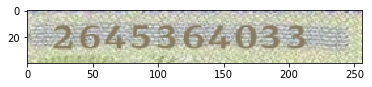

In [6]:
# plt.figure(figsize=(20, 50))
plt.imshow(x_train_normal[9])
plt.show()

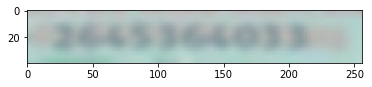

(40, 256, 3)

In [7]:
# x_train_noise = x_train_normal + np.random.normal(loc = 0.0, scale = 0.8, size = x_train_normal.shape)
# x_train_noise = np.clip(x_train_noise, 0., 1.)

# x_test_noise = x_test_normal + np.random.normal(loc = 0.0, scale = 0.8, size = x_test_normal.shape)
# x_test_noise = np.clip(x_test_noise, 0., 1.)

plt.imshow(x_train_noise[9])
plt.show()
x_train_noise[5].shape

In [8]:

autoencoder = Sequential()
#Encoder
autoencoder.add(Conv2D(128,(3,3),activation='relu', padding='same', input_shape=(siz_w, siz_h, 3)))
autoencoder.add(MaxPooling2D((2,2), padding='same'))

autoencoder.add(Conv2D(64,(3,3),activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2), padding='same'))

autoencoder.add(Conv2D(64,(3,3),activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2,2), padding='same'))

# autoencoder.add(Conv2D(32,(3,3),activation='relu', padding='same'))
# autoencoder.add(MaxPooling2D((2,2), padding='same'))

#Decoder
# autoencoder.add(UpSampling2D((2,2)))

# autoencoder.add(Conv2D(32,(3,3),activation='relu', padding='same'))
# autoencoder.add(UpSampling2D((2,2)))

autoencoder.add(Conv2D(64,(3,3),activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))

autoencoder.add(Conv2D(64,(3,3),activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))

autoencoder.add(Conv2D(128,(3,3),activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))

autoencoder.add(Conv2D(3,(3,3), activation='sigmoid', padding='same'))
autoencoder.summary()

INFO:plaidml:Opening device "opencl_nvidia_quadro_rtx_4000.0"
I0721 14:45:18.023746 140186725783360 library.py:135] Opening device "opencl_nvidia_quadro_rtx_4000.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 256, 128)      3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 128, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 128, 64)       73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 32, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 32, 64)         36928     
__________

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

filepath = "denoise_autoencoder_v2.h5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only=True, save_weights_only = True, mode = 'auto', period = 1)
callbacks_list = [checkpoint]
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [10]:
autoencoder.fit(x_train_noise, x_train_normal, 
                epochs=1000, batch_size=32, 
                validation_data=(x_test_noise, x_test_normal), verbose=1)

Train on 7800 samples, validate on 2280 samples
Epoch 1/1000


INFO:plaidml:Analyzing Ops: 114 of 392 operations complete
I0721 14:45:20.318276 140186725783360 library.py:135] Analyzing Ops: 114 of 392 operations complete
INFO:plaidml:Analyzing Ops: 136 of 392 operations complete
I0721 14:45:22.378326 140186725783360 library.py:135] Analyzing Ops: 136 of 392 operations complete


7776/7800 [============================>.] - ETA: 0s - loss: 0.6048- ETA: 0s - loss: 0.6

INFO:plaidml:Analyzing Ops: 106 of 393 operations complete
I0721 14:45:45.178081 140186725783360 library.py:135] Analyzing Ops: 106 of 393 operations complete
INFO:plaidml:Analyzing Ops: 132 of 393 operations complete
I0721 14:45:47.013528 140186725783360 library.py:135] Analyzing Ops: 132 of 393 operations complete


7800/7800 [==============================] - 46s 6ms/step - loss: 0.6049 - val_loss: 0.5909
Epoch 2/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5867 - val_loss: 0.5823
Epoch 3/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5819 - val_loss: 0.5793
Epoch 4/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5795 - val_loss: 0.5777
Epoch 5/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5781 - val_loss: 0.5767
Epoch 6/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5770 - val_loss: 0.5756
Epoch 7/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5762 - val_loss: 0.5750
Epoch 8/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5756 - val_loss: 0.5742
Epoch 9/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5750 - val_loss: 0.5735
Epoch 10/1000
7800/7800 [==============================] - 19s 2ms/s

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5692 - val_loss: 0.5683
Epoch 79/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5693 - val_loss: 0.5682
Epoch 80/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5693 - val_loss: 0.5682
Epoch 81/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5691 - val_loss: 0.5688
Epoch 82/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5692 - val_loss: 0.5682
Epoch 83/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5692 - val_loss: 0.5681
Epoch 84/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5691 - val_loss: 0.5681
Epoch 85/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5691 - val_loss: 0.5684
Epoch 86/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5692 - val_loss: 0.5682
Epoch 87/1000
7800/7800 [==============================] - 1

Epoch 155/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5686 - val_loss: 0.5678
Epoch 156/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5686 - val_loss: 0.5678
Epoch 157/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5686 - val_loss: 0.5676
Epoch 158/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5686 - val_loss: 0.5676
Epoch 159/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5686 - val_loss: 0.5676
Epoch 160/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5686 - val_loss: 0.5677
Epoch 161/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5688 - val_loss: 0.5677
Epoch 162/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5686 - val_loss: 0.5676
Epoch 163/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5685 - val_loss: 0.5676
Epoch 164/1000
7800/7800 [===========

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5684 - val_loss: 0.5675
Epoch 232/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5684 - val_loss: 0.5675
Epoch 233/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5684 - val_loss: 0.5674
Epoch 234/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5684 - val_loss: 0.5674
Epoch 235/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5684 - val_loss: 0.5674
Epoch 236/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5683 - val_loss: 0.5674
Epoch 237/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5684 - val_loss: 0.5674
Epoch 238/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5683 - val_loss: 0.5674
Epoch 239/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5684 - val_loss: 0.5674
Epoch 240/1000
7800/7800 [==========================

7800/7800 [==============================] - 19s 2ms/step - loss: 0.5683 - val_loss: 0.5673
Epoch 308/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5682 - val_loss: 0.5673
Epoch 309/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5683 - val_loss: 0.5673
Epoch 310/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5683 - val_loss: 0.5673
Epoch 311/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5683 - val_loss: 0.5675
Epoch 312/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5683 - val_loss: 0.5673
Epoch 313/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5673
Epoch 314/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5683 - val_loss: 0.5673
Epoch 315/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5683 - val_loss: 0.5674
Epoch 316/1000
7800/7800 [==========================

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 384/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5673
Epoch 385/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5693 - val_loss: 0.5673
Epoch 386/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 387/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 388/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 389/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 390/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 391/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 392/1000
7800/7800 [==========================

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 460/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 461/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 462/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 463/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5684 - val_loss: 0.5674
Epoch 464/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 465/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 466/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 467/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5673
Epoch 468/1000
7800/7800 [==========================

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 536/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 537/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 538/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 539/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 540/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 541/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 542/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 543/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 544/1000
7800/7800 [==========================

7800/7800 [==============================] - 20s 3ms/step - loss: 0.5682 - val_loss: 0.5672
Epoch 612/1000
7800/7800 [==============================] - 20s 3ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 613/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 614/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 615/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 616/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 617/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 618/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 619/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 620/1000
7800/7800 [==========================

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 688/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 689/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 690/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 691/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 692/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 693/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 694/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 695/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 696/1000
7800/7800 [==========================

7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 764/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 765/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 766/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 767/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 768/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 769/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 770/1000
7800/7800 [==============================] - 19s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 771/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 772/1000
7800/7800 [==========================

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 840/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 841/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 842/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 843/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 844/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 845/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 846/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 847/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5672
Epoch 848/1000
7800/7800 [==========================

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5671
Epoch 916/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 917/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 918/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 919/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5681 - val_loss: 0.5671
Epoch 920/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5684 - val_loss: 0.5671
Epoch 921/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 922/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 923/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 924/1000
7800/7800 [==========================

7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 992/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 993/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 994/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5682 - val_loss: 0.5671
Epoch 995/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 996/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 997/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 998/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 999/1000
7800/7800 [==============================] - 18s 2ms/step - loss: 0.5680 - val_loss: 0.5671
Epoch 1000/1000
7800/7800 [=========================

In [11]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test_noise.shape[0], size=num_images)

In [12]:
decoded_imgs = autoencoder.predict(x_test_noise)

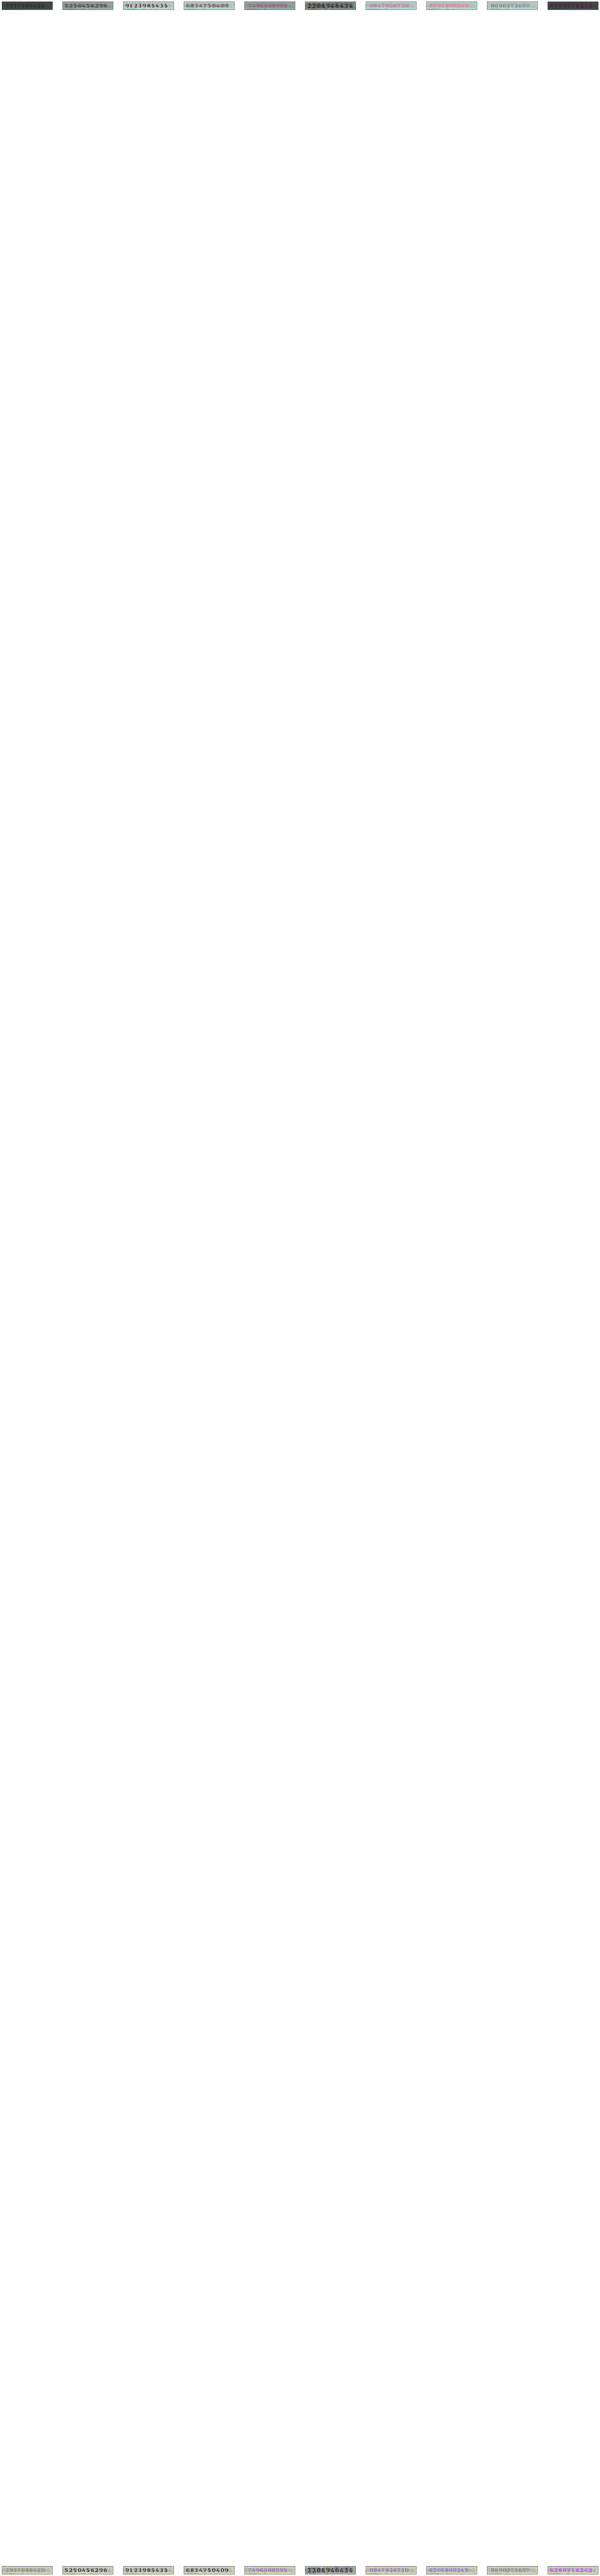

In [13]:
plt.figure(figsize=(40, 250))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test_noise[image_idx].reshape(40, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(40, 256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
autoencoder.save('denoise_autoencoder.h5')
print("Saved !")

INFO:plaidml:Analyzing Ops: 58 of 72 operations complete
I0721 19:51:22.010944 140186725783360 library.py:135] Analyzing Ops: 58 of 72 operations complete


0:00:05.002213


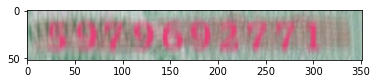

In [15]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
start=datetime.now()

siz_h = 256
siz_w = 40
autoencoder = load_model("denoise_autoencoder.h5")
im = cv2.imread("/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Test_Noise/CMND_Noise/43_10.jpg")
plt.imshow(im)
img = cv2.resize(im,(siz_h,siz_w))
img = np.array(img.reshape(-1, siz_w, siz_h ,3))

max_values = float(img.max())
imgg = img.astype('float')/max_values
x_test_denoised = autoencoder.predict(imgg)
plt.imshow(x_test_denoised.reshape(40,256,3), cmap ='gray')
print (datetime.now()-start)

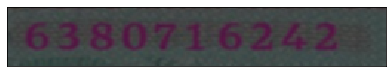

In [19]:
i =3
num_images = 10
np.random.seed(100)
random_test_images = np.random.randint(x_test_normal.shape[0], size = num_images)

x_test_denoised = autoencoder.predict(x_test_noise)

plt.figure(figsize = (80,500))

ax = plt.subplot(2, num_images, i + 1)
plt.imshow(x_test_noise[image_idx].reshape(40,256,3))
plt.gray()
ax.get_xaxis().set_visible(False) 
ax.get_yaxis().set_visible(False) 
plt.show()


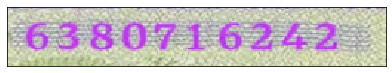

In [20]:
plt.figure(figsize = (80,500))
ax = plt.subplot(2, num_images, num_images + 1 +i)
plt.imshow(x_test_denoised[image_idx].reshape(40, 256, 3))
plt.gray()
ax.get_xaxis().set_visible(False) 
ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# from IPython.display import Image, SVG
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# import keras
# import gzip
# import glob
# import cv2
# import tensorflow as tf
# from tqdm import tqdm
# from random import shuffle
# from keras.datasets import mnist
# from keras.models import Model, Sequential
# from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
# from keras import regularizers



# path_train_nor = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Data_Train/"
# path_train_noi = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Train_Noise/"

# path_test_nor =  "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Data_Test/"
# path_test_noi = "/home/administrator/Desktop/Pham_Thai/Project/Resolution_CMND/Dataset/Test_Noise/"

# data_train_denoise = path_train_nor
# data_train_noise = path_train_noi
# data_test_denoise = path_test_nor
# data_test_noise = path_test_noi

# siz_h = 252
# siz_w = 40

# train_image = []
# for i in tqdm(glob.glob(os.path.join(data_train_denoise, "*", "*"))):
#     path = i
#     print(i)
#     img = cv2.imread(path, cv2.IMREAD_COLOR)
#     img = cv2.resize(img,(siz_h,siz_w))
#     train_image.append([np.array(img)])
#     break
# shuffle(train_image)

# train_image = []
# for i in tqdm(glob.glob(os.path.join(data_train_noise, "*", "*"))):
#     path = i
#     print(i)
#     img = cv2.imread(path, cv2.IMREAD_COLOR)
#     img = cv2.resize(img,(siz_h,siz_w))
#     train_image.append([np.array(img)])
#     break
# shuffle(train_image)